$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 3: Convolutional Architectures
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, when applied to images, convolutional layers operate on and produce volumes (3D tensors) of activations.

A convenient way to interpret convolutional layers for images is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="imgs/cnn_filters.png" width="600" />

A crucial property of convolutional layers is their translation equivariance, i.e. shifting the input results in
and equivalently shifted output.
This produces the ability to detect features regardless of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `hw2/cnn.py` module.
Use PyTorch's `nn.Conv2d` and `nn.MaxPool2d` for the convolution and pooling layers.
It's recommended to implement the missing functionality in the order of the class' methods.

In [3]:
import hw2.cnn as cnn

test_params = [
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=3, stride=1, padding=1),
        activation_type='relu', activation_params=dict(),
        pooling_type='max', pooling_params=dict(kernel_size=2),
    ),
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=5, stride=2, padding=3),
        activation_type='lrelu', activation_params=dict(negative_slope=0.05),
        pooling_type='avg', pooling_params=dict(kernel_size=3),
    ),
]

for i, params in enumerate(test_params):
    torch.manual_seed(seed)

    net = cnn.ConvClassifier(**params)
    print(f"\n=== test {i=} ===")
    print(net)

    test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
    test_out = net(test_image)
    print(f'{test_out=}')

    expected_out = torch.load(f'tests/assets/expected_conv_out_{i:02d}.pt')
    diff = torch.norm(test_out - expected_out).item()
    print(f'{diff=:.3f}')
    test.assertLess(diff, 1e-3)


=== test i=0 ===
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
test_out=tensor([[-0.0868, -0.3790, -0.4341, -0.1236, -0.2160,  0.1683,  0.4739,  0.0750,
          0.1151, -0.1606]], grad_fn=<AddmmBackward>)

Let's load CIFAR-10 again to use as our dataset.

In [4]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `hw2/training.py` module.

In [5]:
import hw2.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = cnn.ConvClassifier(
    in_size, num_classes, channels=[32], pool_every=1, hidden_dims=[100],
    conv_params=dict(kernel_size=3, stride=1, padding=1),
    pooling_params=dict(kernel_size=2),
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(30):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.001, Accuracy 100.0): 100%|██████████████████████████████████| 25/25 [00:00<00:00, 214.59it/s]


### Residual Networks

A very common addition to the basic convolutional architecture described above are **shortcut connections**.
First proposed by [He et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), this simple addition has been shown to be crucial
ingredient in order to achieve effective learning with very deep networks.
Virtually all state of the art image classification models from recent years use this technique.

The idea is to add an shortcut, or skip, around every two or more convolutional layers:

<img src="imgs/resnet_block2.png" width="700" />

This adds an easy way for the network to learn identity mappings: set the weight values to be very small.
The consequence is that the convolutional layers to learn a **residual** mapping, i.e. some delta that is applied
to the identity map, instead of actually learning a completely new mapping from scratch.

Lets start by implementing a general residual block, representing a structure similar to the above diagrams.
Our residual block will be composed of:
- A "main path" with some number of convolutional layers with ReLU between them. Optionally, we'll also apply dropout and  batch normalization layers (in this order) between the convolutions, before the ReLU.
- A "shortcut path" implementing an identity mapping around the main path. In case of a different number of input/output channels, the shortcut path should contain an additional `1x1` convolution to project the channel dimension.
- The sum of the main and shortcut paths output is passed though a ReLU and returned.

**TODO**: Complete the implementation of the `ResidualBlock`'s `__init__()` method in the `hw2/cnn.py` module.

In [6]:
torch.manual_seed(seed)

resblock = cnn.ResidualBlock(
    in_channels=3, channels=[6, 4]*2, kernel_sizes=[3, 5]*2,
    batchnorm=True, dropout=0.2
)

print(resblock)
test_out = resblock(torch.zeros(1, 3, 32, 32))
print(f'{test_out.shape=}')

expected_out = torch.load('tests/assets/expected_resblock_out.pt')
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-3)

ResidualBlock(
  (main_path): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Dropout2d(p=0.2, inplace=False)
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout2d(p=0.2, inplace=False)
    (10): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (shortcut_path): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
test_out.shape=torch.Size([1, 4, 32, 32])


Now, based on the `ResidualBlock`, we'll implement our own variation of a residual network (ResNet),
with the following architecture:

    [-> (CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC
     \------- SKIP ------/
     
Note that $N$, $P$ and $M$ are as before, however now $P$ also controls the number of convolutional layers to add a skip-connection to.

#### Bottleneck Blocks

In the ResNet Block diagram shown above, the right block is called a bottleneck block.
This type of block is mainly used deep in the network, where the feature space becomes increasingly high-dimensional (i.e. there are many channels).

Instead of applying a KxK conv layer on the original input channels, a bottleneck block
first projects to a lower number of features (channels), applies the KxK conv on the result, and then projects back to the original feature space.
Both projections are performed with 1x1 convolutions.

**TODO**: Complete the implementation of the `ResidualBottleneckBlock` in the `hw2/cnn.py` module.

In [7]:
torch.manual_seed(seed)

resblock_bn = cnn.ResidualBottleneckBlock(
    in_out_channels=256, inner_channels=[64, 32, 64], inner_kernel_sizes=[3, 5, 3],
    batchnorm=False, dropout=0.1, activation_type="lrelu"
)
print(resblock_bn)

# Test a forward pass
test_in  = torch.zeros(1, 256, 32, 32)
test_out = resblock_bn(test_in)
print(f'{test_out.shape=}')
assert test_out.shape == test_in.shape 

expected_out = torch.load('tests/assets/expected_resblock_bn_out.pt')
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-3)

ResidualBottleneckBlock(
  (main_path): Sequential(
    (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Dropout2d(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout2d(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Dropout2d(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout2d(p=0.1, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (shortcut_path): Sequential(
    (0): Identity()
  )
)
test_out.shape=torch.Size([1, 256, 32, 32])


**TODO**: Complete the implementation of the `ResNetClassifier` class in the `hw2/cnn.py` module.
You must use your `ResidualBlock`s to group together every $P$ convolutional layers.

In [8]:
torch.manual_seed(seed)

net = cnn.ResNetClassifier(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    activation_type='lrelu', activation_params=dict(negative_slope=0.01),
    pooling_type='avg', pooling_params=dict(kernel_size=2),
    batchnorm=True, dropout=0.1,
)
print(net)

torch.manual_seed(seed)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_out = net(test_image)
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_resnet_out_nofp.pt')
test.assertLess(
    torch.norm(test_out - expected_out).item(), 1e-3
)

ResNetClassifier(
  (feature_extractor): Sequential(
    (0): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Dropout2d(p=0.1, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.01)
        (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): Dropout2d(p=0.1, inplace=False)
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut_path

## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [9]:
net = net.to(device)
test_image = test_image.to(device)
test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [10]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cuda
The model parameter tensors are also on device=cuda:0
The test image is also on device=cuda:0
The output is therefore also on device=cuda:0


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Please don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier` and `ResNetClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. Use at least ~20000 training images and ~6000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified
Files already downloaded and verified
--- EPOCH 1/10 ---
test_batch (Avg. Loss 1.713, Accuracy 38.3): 100%|████████████████████████████████████| 10/10 [00:00<00:00, 179.04it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 1.818, Accuracy 33.3): 100%|████████████████████████████████████| 10/10 [00:00<00:00, 185.68it/s]
--- EPOCH 10/10 ---
test_batch (Avg. Loss 1.907, Accuracy 28.3): 100%|████████████████████████████████████| 10/10 [00:00<00:00, 175.66it/s]
{'num_epochs': 0, 'train_loss': [2.278109312057495, 2.197352409362793, 2.093388319015503, 2.0592381954193115, 1.9892653226852417, 1.9437109231948853, 1.838093638420105, 1.9094778299331665, 1.8455816507339478, 1.7578951120376587], 'train_acc': [12.4, 18.4, 22.4, 20.0, 26.0, 30.0, 32.8, 33.2, 33.2, 34.4], 'test_loss': [2.214958429336548, 2.1117751598358154, 2.0819435119628906, 1.996536135673523, 2.0463500022888184, 1.712776780128479, 1.7892698049545288, 1.7796815633773804, 1.818074107170105, 1.907336115

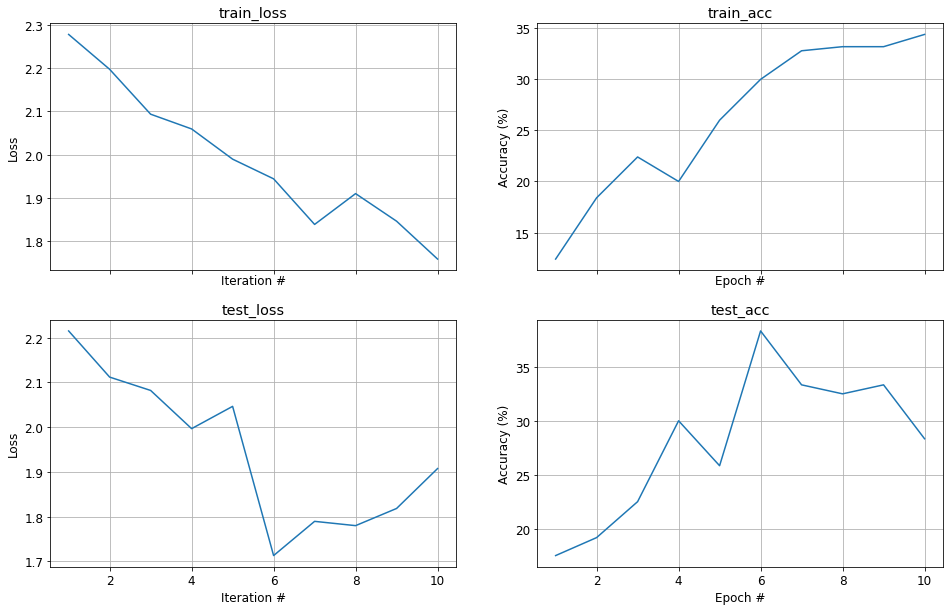

In [12]:
import hw2.experiments as experiments
from hw2.experiments import load_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [13]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [24]:
plot_exp_results('exp1_1_L*_K32*.json')

No results found for pattern exp1_1_L*_K32*.json.


In [ ]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[256]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[256]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [ ]:
plot_exp_results('exp1_2_L2*.json')

In [ ]:
plot_exp_results('exp1_2_L4*.json')

In [ ]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`. 

**TODO**: Run the experiment on the above configuration  with the `ConvClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [ ]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNetClassifier` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [ ]:
plot_exp_results('exp1_4_L*_K32.json')

In [ ]:
plot_exp_results('exp1_4_L*_K64*.json')

### Experiment 2: Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections, bottlenecks
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures (e.g. inception module)

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw2/cnn.py` module.

In [ ]:
net = cnn.YourCodeNet((3,100,100), 10, channels=[32]*4, pool_every=2, hidden_dims=[100]*2)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_out = net(test_image)
print('out =', test_out)

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[32, 64, 128]` fixed with `L=3,6,9,12` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

If you want, you can add some extra runs following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L3_K32-64-128`. 

**TODO**: Run the experiment on the above configuration with the `YourCodeNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

In [ ]:
plot_exp_results('exp2*.json')

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1

Consider the bottleneck block from the right side of the ResNet diagram above.
Compare it to a regular block that performs a two 3x3 convs directly on the 256-channel input (i.e. as shown in the left side of the diagram, with a different number of channels).
Explain the differences between the regular block and the bottleneck block in terms of:

1. Number of parameters. Calculate the exact numbers for these two examples.
2. Number of floating point operations required to compute an output (qualitative assessment).
3. Ability to combine the input: (1) spatially (within feature maps); (2) across feature maps.


In [ ]:
display_answer(hw2.answers.part3_q1)

### Question 2 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [ ]:
display_answer(hw2.answers.part3_q2)

### Question 3 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [ ]:
display_answer(hw2.answers.part3_q3)

### Question 4 

Analyze your results from experiment 1.3.

In [ ]:
display_answer(hw2.answers.part3_q4)

### Question 5

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [ ]:
display_answer(hw2.answers.part3_q5)

### Question 6

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [ ]:
display_answer(hw2.answers.part3_q6)